# Part 1
#### Assignment
Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. 
- Show how different parameters passed to the Classifier affect the overfitting issue. 
- Perform cross-validation to mitigate the overfitting of your model. 

Once you assessed your model,
- inspect the `feature_importances_` attribute and discuss the obtained results. 
- With different assumptions on the data (e.g., dropping certain features evenbefore feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

## Plan
First we will just lok at the Random Forest classifier without any parameters (just use the default) -> gives very good scores 

Look a bit at the feature_importances

Then we see that it is better to aggregate the data by player (We can't show overfitting with 'flawed' data and very good scores, so we first aggregate)

Aggregate

Look again at the classifier with default parameters

Show the effect of some parameters to overfitting

Find acceptable values of parameters

Inspect the feature_importances

drop some and see impact on feature_importances


In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing as pp
from sklearn.model_selection import KFold , cross_val_score, train_test_split, validation_curve
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score

import sklearn.preprocessing as preprocessing

%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns

Load the preprocessed data and look at it.

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st_preprocessed_encoded.csv', index_col=0)
data_total = data.copy()
print('Number of dayads', data.shape)
data.head()

Number of dayads (124468, 29)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,color_rating
0,901,1046,70,3,1382,177.0,72.0,0,1,0,0,1,0,0,0,0,1532,0.25,0.50,1,1,59,0.326391,712.0,0.000564,0.396000,750.0,0.002696,2
1,739,919,51,1,320,179.0,82.0,12,1,0,0,1,0,1,0,0,497,0.75,0.75,2,2,153,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,4
5,0,392,34,0,360,182.0,71.0,1,1,0,0,1,0,0,0,0,1081,0.25,0.00,4,4,87,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1
6,45,425,48,0,446,187.0,80.0,7,1,1,0,0,0,0,0,0,1175,0.00,0.25,4,4,87,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1
7,64,440,54,0,158,180.0,68.0,4,1,0,0,1,0,0,0,0,803,1.00,1.00,4,4,87,0.325185,127.0,0.003297,0.538462,130.0,0.013752,5


In [3]:
print('Number of diads: ', len(data))
print('Number of players: ', len(data.playerShort.unique()))
print('Number of referees: ', len(data.refNum.unique()))

Number of diads:  124468
Number of players:  1585
Number of referees:  2967


## Train RF

First we just train and test the preprocessed data with the default values of the Random Forest to see what happens.
For this first model, we will use all the features (except rater1,rater2, color_rating) and then we will observe which are the most important.


In [4]:
player_colors = data['color_rating']
rf_input_data = data.drop(['rater1', 'rater2', 'color_rating'], axis=1)

In [5]:
rf = RandomForestClassifier()
result = cross_val_score(rf, rf_input_data, player_colors, cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=3)
result

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.901759 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.908090 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.908740 -   0.1s
[CV]  ................................................................
[CV] ....................................... , score=0.908090 -   0.1s
[CV]  ................................................................
[CV] ....................................... , score=0.902306 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.908090 -   0.1s
[CV]  

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   11.4s finished


array([ 0.90175918,  0.90874036,  0.9080903 ,  0.9080903 ,  0.90230578,
        0.9080903 ,  0.90238612,  0.91121646,  0.9050221 ,  0.8588188 ])

Quite good results...

## Observe the important features

In [6]:
def show_important_features_random_forest(X, y, rf=None):
    if rf is None:
        rf = RandomForestClassifier()

    rf.fit(X, y)

    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    cols = X.columns
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature n° %d %s (%f)" % (f + 1, indices[f], cols[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()  


Feature ranking:
1. feature n° 16 photoID (0.116911)
2. feature n° 1 player (0.115163)
3. feature n° 4 birthday (0.106977)
4. feature n° 0 playerShort (0.104491)
5. feature n° 2 club (0.101289)
6. feature n° 5 height (0.094127)
7. feature n° 6 weight (0.092560)
8. feature n° 7 position (0.080473)
9. feature n° 17 refNum (0.042917)
10. feature n° 3 leagueCountry (0.028149)
11. feature n° 8 games (0.013917)
12. feature n° 9 victories (0.012396)
13. feature n° 11 defeats (0.011056)
14. feature n° 10 ties (0.009991)
15. feature n° 21 nIAT (0.007992)
16. feature n° 23 meanExp (0.007498)
17. feature n° 13 yellowCards (0.007497)
18. feature n° 12 goals (0.007386)
19. feature n° 22 seIAT (0.007212)
20. feature n° 18 refCountry (0.006745)
21. feature n° 19 Alpha_3 (0.006653)
22. feature n° 20 meanIAT (0.006382)
23. feature n° 25 seExp (0.005889)
24. feature n° 24 nExp (0.005204)
25. feature n° 15 redCards (0.000582)
26. feature n° 14 yellowReds (0.000545)


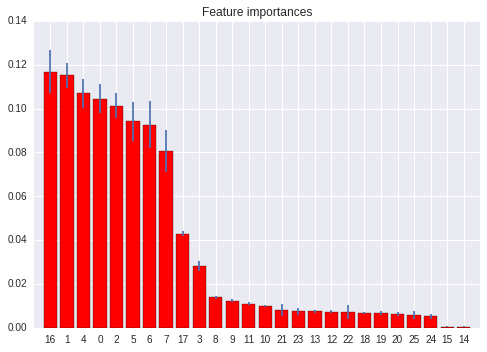

In [7]:
show_important_features_random_forest(rf_input_data, player_colors)

We can see that the most important features are:
    - photoID
    - player
    - the birthday
    - playerShort
    
The obtained result is weird. Those 4 features seem to be independant of the color skin and they shloud also be unique to one player. PhotoID is the id of the photo and thus unique for one player. Same about 'player' and 'playerShort' (both represent the players name). Birthday is not necessarily unique, but should not be that important for the skin color.

We have to remember that our data contains dayads between player and referee, so a player can appear several times in our data. It could be the reason why the name is imprtant. Let's look at the data:

In [8]:
data.playerShort.value_counts()[:10]

415     202
732     197
681     196
541     195
1552    188
587     183
1226    181
1578    181
1388    180
603     177
Name: playerShort, dtype: int64

Indeed, some players appear around 200 times, so it is easy to determine the skin-color of _djibril cisse_ if he appears both in the training set and in the test set. But in the reality the probability to have 2 _djibril cisse_ with the same birthday and same color skin is almost null.
The reason why this attributes are so important is that some of the rows of one player appear in the train and test set, so the classifier can take those to determine the skin-color.

Now we drop those attributes and see what happens.

In [9]:
rf_input_data_drop = rf_input_data.drop(['birthday', 'player','playerShort', 'photoID'], axis=1)

In [10]:
rf = RandomForestClassifier()
result = cross_val_score(rf, rf_input_data_drop, player_colors, cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=3)

result

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.764881 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.834913 -   0.1s
[CV]  ................................................................
[CV] ....................................... , score=0.835864 -   0.1s
[CV]  ................................................................
[CV] ....................................... , score=0.844219 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.853137 -   0.1s
[CV]  ................................................................
[CV] ....................................... , score=0.844380 -   0.1s
[CV]  

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    9.2s finished


array([ 0.76488071,  0.83491324,  0.83586406,  0.84421949,  0.84438017,
        0.8531373 ,  0.84052382,  0.85666077,  0.84162314,  0.72069104])

As expected the accuracy of the classifier dropped.

Feature ranking:
1. feature n° 3 weight (0.177984)
2. feature n° 2 height (0.175373)
3. feature n° 0 club (0.174736)
4. feature n° 4 position (0.126003)
5. feature n° 13 refNum (0.080076)
6. feature n° 1 leagueCountry (0.035280)
7. feature n° 5 games (0.031651)
8. feature n° 6 victories (0.029119)
9. feature n° 8 defeats (0.023987)
10. feature n° 7 ties (0.021418)
11. feature n° 10 yellowCards (0.018120)
12. feature n° 9 goals (0.017725)
13. feature n° 19 meanExp (0.012820)
14. feature n° 16 meanIAT (0.011499)
15. feature n° 18 seIAT (0.011019)
16. feature n° 14 refCountry (0.010489)
17. feature n° 21 seExp (0.010411)
18. feature n° 15 Alpha_3 (0.010338)
19. feature n° 20 nExp (0.009625)
20. feature n° 17 nIAT (0.009029)
21. feature n° 12 redCards (0.001690)
22. feature n° 11 yellowReds (0.001607)


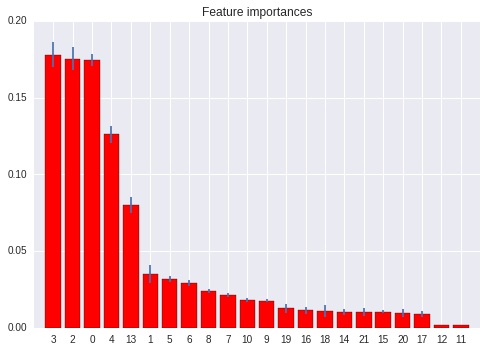

In [11]:
show_important_features_random_forest(rf_input_data_drop, player_colors)

That makes more sence, it is possible that dark persons are statistically taller than white persons, but the club and position should not be that important. So we decided to aggregate on the players name.

We do the aggregation in the _HW04-1-Preprocessing_ notebook.

In [12]:
data_aggregated = pd.read_csv('CrowdstormingDataJuly1st_aggregated_encoded.csv')
data_aggregated.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,color_rating,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr
0,0,392,34,0,360,182.0,71.0,1,654,247,179,228,9,19,0,0,0.25,0.00,166,37,0.346459,0.003297,0.494575,0.013752,1,0.328409,0.367721,0.333195,0.400637
1,1,393,91,2,176,183.0,73.0,0,336,141,73,122,62,42,0,1,0.00,0.25,99,25,0.348818,0.003297,0.449220,0.013752,2,0.329945,0.441615,0.341438,0.380811
2,2,394,83,0,719,165.0,63.0,11,412,200,97,115,31,11,0,0,0.25,0.25,101,28,0.345893,0.003297,0.491482,0.013752,2,0.328230,0.365628,0.332389,0.399459
3,3,395,6,0,1199,178.0,76.0,3,260,150,42,68,39,31,0,1,0.00,0.00,104,37,0.346821,0.003297,0.514693,0.013752,1,0.327775,0.412859,0.336638,0.433294
4,4,396,51,1,758,180.0,73.0,1,124,41,40,43,1,8,4,2,0.25,0.25,37,11,0.331600,0.000151,0.335587,0.000586,2,0.338847,0.379497,0.331882,0.328895


## Aggregated data
the same inspection as above

In [13]:
rf = RandomForestClassifier()
aggr_rf_input_data = data_aggregated.drop(['rater1', 'rater2', 'color_rating'], axis=1)
aggr_player_colors = data_aggregated['color_rating']

result = cross_val_score(rf, aggr_rf_input_data, aggr_player_colors, cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=3)
result

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.400000 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.418750 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.431250 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.383648 -   0.0s
[CV] ....................................... , score=0.398734 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.443038 -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished


array([ 0.41875   ,  0.43125   ,  0.4       ,  0.3836478 ,  0.39873418,
        0.40506329,  0.41139241,  0.39240506,  0.44303797,  0.42307692])

In [14]:
#normalize input_data test -> has no influence
#aggr_rf_input_data_scaled = aggr_rf_input_data.apply(lambda c: c/c.max(), axis=0)
#cross_val_score(rf, aggr_rf_input_data_scaled, aggr_player_colors, cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=3)

Feature ranking:
1. feature n° 4 birthday (0.051553)
2. feature n° 25 meanExp_GameNbr (0.050413)
3. feature n° 1 player (0.050188)
4. feature n° 9 victories (0.050113)
5. feature n° 18 meanIAT (0.049159)
6. feature n° 10 ties (0.047657)
7. feature n° 11 defeats (0.047184)
8. feature n° 23 meanExp_nExp (0.046491)
9. feature n° 2 club (0.045670)
10. feature n° 22 meanIAT_nIAT (0.043586)
11. feature n° 0 playerShort (0.042526)
12. feature n° 12 goals (0.041402)
13. feature n° 24 meanIAT_GameNbr (0.041053)
14. feature n° 6 weight (0.040639)
15. feature n° 5 height (0.040350)
16. feature n° 13 yellowCards (0.039893)
17. feature n° 16 refCount (0.039514)
18. feature n° 20 meanExp (0.038890)
19. feature n° 17 refCountryCount (0.036449)
20. feature n° 7 position (0.032304)
21. feature n° 8 games (0.030145)
22. feature n° 19 seIAT (0.024815)
23. feature n° 21 seExp (0.021962)
24. feature n° 3 leagueCountry (0.017824)
25. feature n° 14 yellowReds (0.016401)
26. feature n° 15 redCards (0.013821)


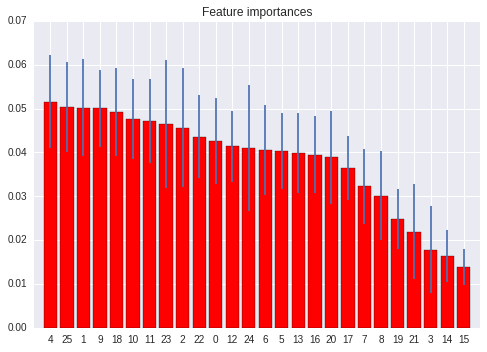

In [15]:
show_important_features_random_forest(aggr_rf_input_data, aggr_player_colors)

That makes a lot more sense. The features are much more equal and interestingly meanIAT plays the most important role. But before going more into detail, we adress the overfitting issue mentioned in the assignment.

## Show overfitting issue
The classifier overfitts when the Training error is much lower than the testing error.

The (in our eyes important) parameters of the RF concerning overfitting are:
- n_estimators: how many trees -> the more threes the less overfitting since they balance each other out
- max_depth: the max depth of the tree -> the deeper the more overfitting is possible
- min_samples_leaf: The minimum number of samples required to be at a leaf node -> the smaller, the higher the possible overfitting

So to overfit we choose few trees (say, 3), unbounded max depth (None) and min samples 1.
To counter the overfitting we take higher values for a second tree.

To show the impact of each parameter we try different out and plot the train vs test error.
Luckily there is a function for this :D

In [16]:
# n_estimators
train_scores_estims, valid_scores_estims = validation_curve(
    RandomForestClassifier(), aggr_rf_input_data, aggr_player_colors, 
    "n_estimators", range(1, 30), n_jobs=10,verbose=1)

[Parallel(n_jobs=10)]: Done  87 out of  87 | elapsed:    2.1s finished


In [17]:
# max_depth
train_scores_depth, valid_scores_depth = validation_curve(
    RandomForestClassifier(), aggr_rf_input_data, aggr_player_colors, 
    "max_depth", range(1, 30), n_jobs=10,verbose=1)

[Parallel(n_jobs=10)]: Done  87 out of  87 | elapsed:    1.4s finished


In [18]:
# min_samples_leaf
train_scores_leaf, valid_scores_leaf = validation_curve(
    RandomForestClassifier(), aggr_rf_input_data, aggr_player_colors, 
    "min_samples_leaf", range(1, 100), n_jobs=3,verbose=1)

[Parallel(n_jobs=3)]: Done 297 out of 297 | elapsed:    4.2s finished


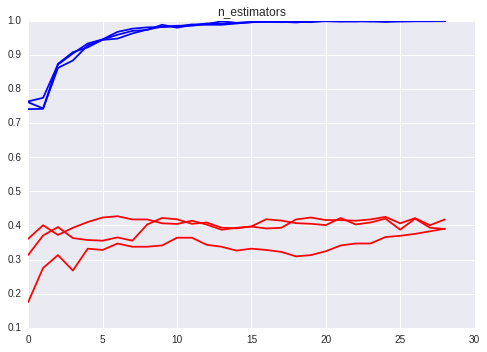

In [19]:
plt.plot(train_scores_estims, color='b', label="train error")
plt.plot(valid_scores_estims, color='r', label="test error")
plt.title("n_estimators")
plt.show()

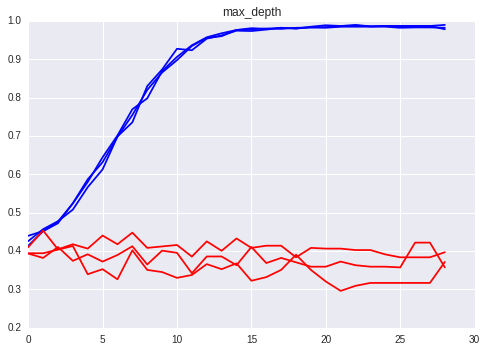

In [20]:
plt.plot(train_scores_depth, color='b', label="train error")
plt.plot(valid_scores_depth, color='r', label="test error")
plt.title("max_depth")
plt.show()

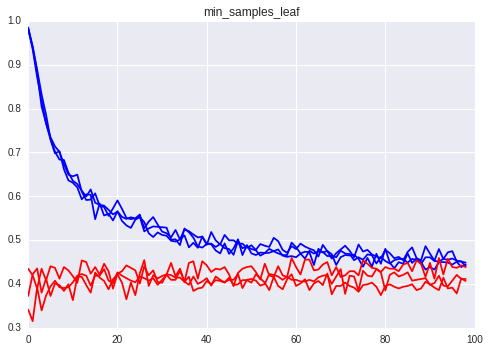

In [21]:
plt.plot(train_scores_leaf, color='b', label="train error")
plt.plot(valid_scores_leaf, color='r', label="test error")
plt.title("min_samples_leaf")
plt.show()

It can be seen that the higher the max_depth, the higher is the overfitting. The same is true for the min_samples only in reverse. n_estimators ... words ... TODO